In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cpa
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os 
from tqdm import tqdm
sc.set_figure_params(dpi=100, frameon=False,fontsize=12)
sc.logging.print_header()

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.21.5 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.1 python-igraph==0.9.9 louvain==0.7.1 pynndescent==0.5.6


In [3]:
adata = sc.read(f'/storage/groups/ml01/workspace/carlo.dedonno/cpa-reproducibility/datasets/Norman2019_prep_new.h5ad')

In [ ]:
from tqdm import tqdm
adata_preds = []
for split in np.arange(1, 25):
    est = []
    adata_split = adata[adata.obs[f'split{split}'] == 'train'].copy()
    for i, ko_A in enumerate(tqdm(single_perturb_ids)):
        for j, ko_B in enumerate(single_perturb_ids[i+1:]):
            mean_A = adata_split.X[adata_split.obs.condition.str.contains(ko_A)].mean(axis=0)
            mean_B = adata_split.X[adata_split.obs.condition.str.contains(ko_B)].mean(axis=0) 
            AB_est = np.asarray((mean_A + mean_B) / 2)
            est.append({
                'ko_A': ko_A,
                'ko_B': ko_B,
                'X': AB_est,
            })
    df = pd.DataFrame(est)
    adata_pred = sc.AnnData(
        X=np.vstack(df.X.values),
        obs=df[['ko_A', 'ko_B']]
    )
    adata_pred.obs['split'] = split
    adata_preds.append(adata_pred)

In [ ]:
adata_pred = adata_preds[0].concatenate(adata_preds[1:])

In [35]:
adata_pred.write('linear_preds_norman.h5ad')

... storing 'ko_A' as categorical
... storing 'ko_B' as categorical
... storing 'condition' as categorical
... storing 'condition_' as categorical


In [30]:
adata_pred = sc.read('linear_preds_norman.h5ad')

In [31]:
adata_pred.obs['condition'] = adata_pred.obs[['ko_A', 'ko_B']].apply(lambda x: '+'.join(x), axis=1)
adata_pred.obs['condition_'] = adata_pred.obs[['ko_B', 'ko_A']].apply(lambda x: '+'.join(x), axis=1)

In [32]:
adata_split = adata[adata.obs[f'split2'] == 'ood'].copy()

In [34]:
from sklearn.metrics import r2_score

In [35]:
r2_list = []
for split in np.arange(2, 15):
    adata_split = adata[adata.obs[f'split{split}'] == 'ood'].copy()
    adata_pred_split = adata_pred[adata_pred.obs[f'split'] == split].copy()
    ood_cond = adata_split.obs['condition'].unique()
    for cond in ood_cond:
        est_gexp = adata_pred_split.X[(adata_pred_split.obs['condition'] == cond) | (adata_pred_split.obs['condition_'] == cond)]
        real_gexp = adata_split.X[(adata_split.obs['condition'] == cond)].mean(axis=0)
        de_genes = adata_split.uns['rank_genes_groups_cov'][f'A549_{cond}_1+1']
        de_genes_idx = np.where(adata_split.var_names.isin(de_genes))
        r2 = r2_score(np.squeeze(np.asarray(real_gexp)), np.squeeze(est_gexp))
        r2_deg = r2_score(np.squeeze(np.asarray(real_gexp))[de_genes_idx], np.squeeze(est_gexp)[de_genes_idx])
        
        r2_list.append(
            {
                'cond': cond,
                'r2': r2,
                'r2_deg': r2_deg,
                'split': split,
            }
        )

In [36]:
df = pd.DataFrame(r2_list)

In [37]:
df=df.melt(id_vars=['cond', 'split'])

<AxesSubplot:xlabel='variable', ylabel='value'>

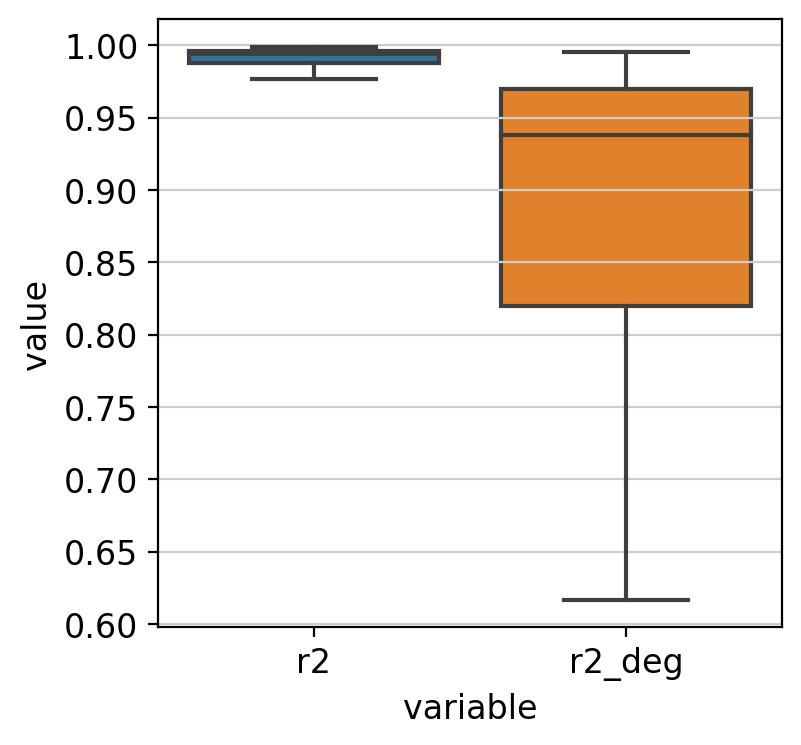

In [38]:
sns.boxplot(y='value', x='variable', data=df, showfliers=False)

In [51]:
import cpa
adata_random = sc.pp.subsample(adata, n_obs=1000, copy=True)
df_list = []
for split in np.arange(2, 15):
    adata_random = sc.pp.subsample(adata[adata.obs[f'split{split}']=='train'], n_obs=1000, copy=True)
    print(split)
    cpa_api = cpa.api.API(
        adata,
        pretrained=f'../seml/norman_splits_models/model_split{split}.pt',
        device='cpu'
    )

    genes_control = cpa_api.datasets['test'].subset_condition(control=True).genes
    df_ood = cpa_api.evaluate_r2(cpa_api.datasets['ood'], genes_control, adata_random.X.A)
    df_ood['benchmark'] = 'CPA'
    df_ood['split'] = 'ood'
    df_ood['model_split'] = split
    df_list.append(df_ood)

2
Loaded pretrained model from:	../seml/norman_splits_models/model_split2.pt
3
Loaded pretrained model from:	../seml/norman_splits_models/model_split3.pt
4
Loaded pretrained model from:	../seml/norman_splits_models/model_split4.pt
5
Loaded pretrained model from:	../seml/norman_splits_models/model_split5.pt
6
Loaded pretrained model from:	../seml/norman_splits_models/model_split6.pt
7
Loaded pretrained model from:	../seml/norman_splits_models/model_split7.pt
8
Loaded pretrained model from:	../seml/norman_splits_models/model_split8.pt
9
Loaded pretrained model from:	../seml/norman_splits_models/model_split9.pt
10
Loaded pretrained model from:	../seml/norman_splits_models/model_split10.pt
11
Loaded pretrained model from:	../seml/norman_splits_models/model_split11.pt
12
Loaded pretrained model from:	../seml/norman_splits_models/model_split12.pt
13
Loaded pretrained model from:	../seml/norman_splits_models/model_split13.pt
14
Loaded pretrained model from:	../seml/norman_splits_models/model_

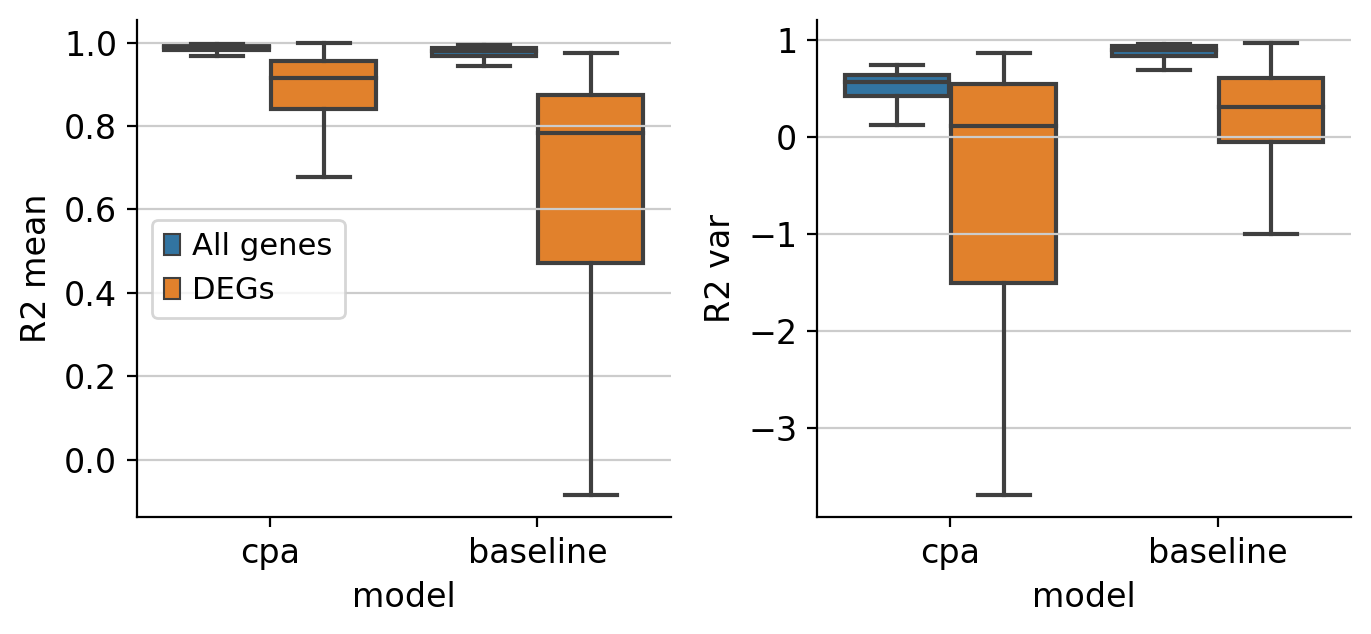

In [52]:
df_plot = pd.concat(df_list)
df_plot = df_plot.melt(id_vars=['cell_type', 'condition', 'dose_val', 'model', 'num_cells', 'model_split', 'split'])
df_plot = df_plot[df_plot['split'] == 'ood']
fig, ax = plt.subplots(1, 2, figsize=(7, 3.3))
sns.boxplot(
    x='model', 
    y='value', 
    hue='variable', 
    data=df_plot[df_plot.variable.str.contains('mean')], 
    showfliers=False,
    ax=ax[0]
)
sns.boxplot(
    x='model', 
    y='value', 
    hue='variable', 
    data=df_plot[df_plot.variable.str.contains('var')], 
    showfliers=False,
    ax=ax[1]
)
ax[0].set_xlabel('model')
ax[1].set_xlabel('model')
ax[0].set_ylabel('R2 mean')
ax[1].set_ylabel('R2 var')
handles, _ = ax[0].get_legend_handles_labels()
ax[0].legend(handles, ['All genes', 'DEGs'])
ax[1].get_legend().remove()
sns.despine()
fig.tight_layout()
#fig.savefig('figures/suppfig_sciplex2/evaluation.png', dpi=600, bbox_inches='tight')

In [53]:
d = df_plot[df_plot.variable.str.contains('mean')]
d = d[d['model'] == 'cpa']

In [54]:
d_bl = df_plot[df_plot.variable.str.contains('mean')]
d_bl = d_bl[d_bl['model'] == 'baseline']

In [55]:
df = df.assign(model='linear')
df['variable'][df['variable'] == 'r2'] = 'R2_mean'
df['variable'][df['variable'] == 'r2_deg'] = 'R2_mean_DE'
d = d.assign(model='cpa')
d_bl = d_bl.assign(model='baseline')
d_merged = pd.concat([d, df, d_bl])

In [56]:
d_merged['value'] = d_merged['value'].astype(float)

In [8]:
df_plot = pd.read_csv('df_norman.csv')
d_merged = pd.read_csv('df_norman_wlinear.csv')

In [11]:
d_merged['model'][d_merged['model']=='cpa'] = 'CPA'
d_merged['variable'][d_merged['variable']=='R2_mean'] = 'R2 mean'
d_merged['variable'][d_merged['variable']=='R2_mean_DE'] = 'R2 mean (DEG)'

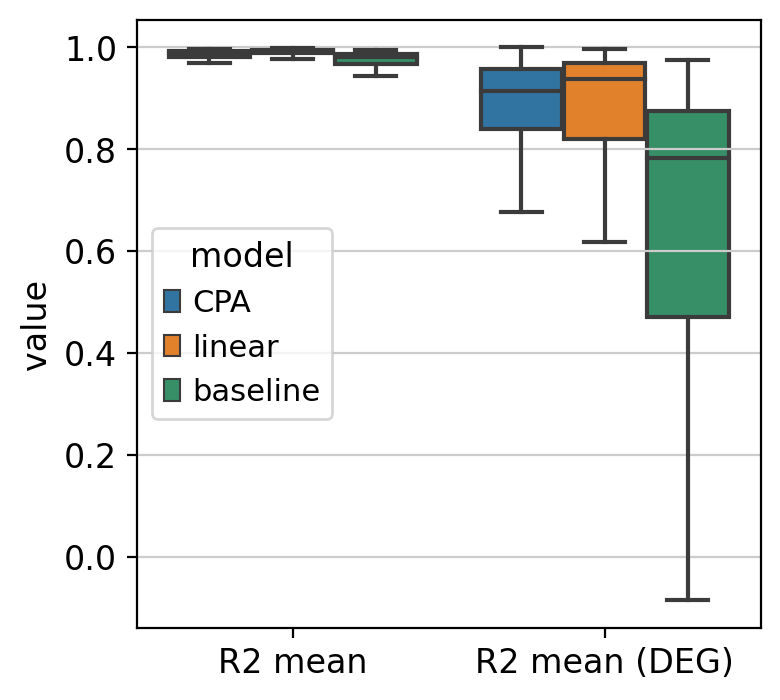

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharey=True)
sns.boxplot(y='value', x='variable', hue='model', data=d_merged, showfliers=False, ax=ax)
ax.set_xlabel('')
#ax.grid(False)
fig.savefig('figures/baseline_norman.png', dpi=600)
#sns.despine()

In [58]:
df_plot.to_csv('df_norman.csv')